# Imports and helper functions

In [2]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt

FILES_WEEKDAY = {
    'non_cbd_24': 'NonCBD_2024_Thu.csv',
    'cbd_24':     'CBD_2024_Thu.csv',
    'non_cbd_25': 'NonCBD_2025_Thu.csv',
    'cbd_25':     'CBD_2025_Thu.csv'
}

FILES_WEEKEND = {
    'non_cbd_24': 'NonCBD_2024_Sat.csv',
    'cbd_24':     'CBD_2024_Sat.csv',
    'non_cbd_25': 'NonCBD_2025_Sat.csv',
    'cbd_25':     'CBD_2025_Sat.csv'
}

DATASETS = [
    ('non_cbd_24', False, False),
    ('cbd_24', True, False),
    ('non_cbd_25', False, True),
    ('cbd_25', True, True),
]


def load_and_prep_exclusive(file_path, is_treated, is_post, target_hours):
    """Aggregate trips after excluding origins inside the destination region."""
    df = pd.read_csv("data/" + file_path)

    df['end_dt'] = pd.to_datetime(df['trip_end_time'], format='%H:%M:%S', errors='coerce')
    df['hour'] = df['end_dt'].dt.hour
    df = df[df['hour'].isin(target_hours)]

    df = df[df['origin_trct_2020'] != 'Out of Region']
    df['origin_bgrp_2020'] = df['origin_bgrp_2020'].fillna('').astype(str).str.strip()
    df = df[df['origin_bgrp_2020'] != 'Out of Region']

    dest_values = (
        df['destination_bgrp_2020']
        .fillna('')
        .astype(str)
        .str.strip()
    )
    dest_set = {val for val in dest_values if val and val.lower() != 'nan' and val != 'Out of Region'}
    df = df[~df['origin_bgrp_2020'].isin(dest_set)]

    group_type = 'CBD' if is_treated else 'NonCBD'
    df['od_id'] = df['origin_trct_2020'].astype(str) + '_' + group_type

    df_agg = df.groupby('od_id').size().reset_index(name='volume')
    df_agg['treated'] = 1 if is_treated else 0
    df_agg['post'] = 1 if is_post else 0
    df_agg['year'] = 2025 if is_post else 2024
    return df_agg

In [3]:
def estimate_hourly_effects(label, file_mapping, significance=0.05, hours=range(24)):
    """Estimate DID log-volume treatment effects separately for each hour."""
    results = []
    for hour in hours:
        frames = [
            load_and_prep_exclusive(file_mapping[key], treated, post, [hour])
            for key, treated, post in DATASETS
        ]
        df_raw = pd.concat(frames, ignore_index=True)
        if df_raw.empty:
            continue
        all_ods = df_raw[['od_id', 'treated']].drop_duplicates()
        years = pd.DataFrame({'year': [2024, 2025], 'post': [0, 1]})
        df_balanced = all_ods.merge(years, how='cross')
        df_final = df_balanced.merge(df_raw[['od_id', 'year', 'volume']], on=['od_id', 'year'], how='left')
        df_final['volume'] = df_final['volume'].fillna(0)
        df_final['did'] = df_final['treated'] * df_final['post']
        df_final['log_volume'] = np.log1p(df_final['volume'])

        df_fe = df_final.set_index(['od_id', 'year'])

        model = PanelOLS.from_formula('log_volume ~ post + did + EntityEffects', data=df_fe)
        res = model.fit()

        coef_did = res.params['did']
        p_value = res.pvalues['did']
        pct_change = (np.exp(coef_did) - 1) * 100
        ci_low, ci_high = res.conf_int().loc['did']
        ci_lower_pct = (np.exp(ci_low) - 1) * 100
        ci_upper_pct = (np.exp(ci_high) - 1) * 100

        results.append({
            'hour': hour,
            'coef_did': coef_did,
            'p_value': p_value,
            'pct_change': pct_change,
            'ci_lower': ci_low,
            'ci_upper': ci_high,
            'ci_lower_pct': ci_lower_pct,
            'ci_upper_pct': ci_upper_pct,
            'significant': p_value < significance
        })

    result_df = pd.DataFrame(results)
    print(f"=== {label} Hourly Treatment Effects ===")
    if result_df.empty:
        print('No data available for any hour after filtering.')
    else:
        print(result_df)
    return result_df


# Run the experiments
Takes about 4 minutes on 2020 M1 MacBook Pro

In [4]:
weekday_hourly_effects = estimate_hourly_effects(
    'Weekday Outside-Zone',
    FILES_WEEKDAY,
    significance=0.05,
    hours=range(24),
)

weekend_hourly_effects = estimate_hourly_effects(
    'Weekend Outside-Zone',
    FILES_WEEKEND,
    significance=0.1,
    hours=range(24),
)

/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_58443/4193360104.py:30: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/" + file_path)
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_58443/4193360104.py:30: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/" + file_path)
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_58443/4193360104.py:30: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/" + file_path)
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_58443/4193360104.py:30: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/" + file_path)
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_58443/4193360104.py:30: DtypeWarning: Columns

=== Weekday Outside-Zone Hourly Treatment Effects ===
    hour  coef_did       p_value  pct_change  ci_lower  ci_upper  \
0      0  0.141918  1.551238e-02   15.248196  0.027074  0.256762   
1      1  0.168254  5.040745e-02   18.323703 -0.000301  0.336808   
2      2  0.117432  2.247135e-01   12.460565 -0.072635  0.307500   
3      3  0.311106  1.138054e-07   36.493440  0.197074  0.425139   
4      4  0.028026  5.157513e-01    2.842293 -0.056540  0.112593   
5      5 -0.141797  1.252555e-05  -13.220289 -0.205352 -0.078242   
6      6 -0.246973  0.000000e+00  -21.883790 -0.304395 -0.189550   
7      7 -0.153426  9.403149e-08  -14.223535 -0.209700 -0.097151   
8      8 -0.161373  9.081203e-09  -14.902499 -0.216339 -0.106406   
9      9 -0.175392  2.245071e-11  -16.087234 -0.226697 -0.124088   
10    10 -0.125257  2.983317e-07  -11.772995 -0.173117 -0.077397   
11    11 -0.068049  4.185657e-03   -6.578522 -0.114611 -0.021487   
12    12 -0.056568  1.476625e-02   -5.499738 -0.102037 -0.0110

/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_58443/4193360104.py:30: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/" + file_path)
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_58443/4193360104.py:30: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/" + file_path)
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_58443/4193360104.py:30: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/" + file_path)
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_58443/4193360104.py:30: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/" + file_path)
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_58443/4193360104.py:30: DtypeWarning: Columns

=== Weekend Outside-Zone Hourly Treatment Effects ===
    hour  coef_did   p_value  pct_change  ci_lower  ci_upper  ci_lower_pct  \
0      0  0.042212  0.598101    4.311530 -0.115102  0.199525    -10.872435   
1      1  0.029341  0.779658    2.977615 -0.177253  0.235936    -16.243236   
2      2 -0.006515  0.961860   -0.649334 -0.275772  0.262743    -24.101427   
3      3  0.106424  0.154715   11.229385 -0.040285  0.253134     -3.948457   
4      4  0.031092  0.586423    3.158027 -0.081033  0.143217     -7.783661   
5      5 -0.031725  0.456982   -3.122696 -0.115357  0.051907    -10.895210   
6      6  0.014424  0.649942    1.452887 -0.047884  0.076733     -4.675566   
7      7 -0.049388  0.095630   -4.818870 -0.107480  0.008703    -10.190558   
8      8 -0.103257  0.000252   -9.810519 -0.158522 -0.047993    -14.659554   
9      9 -0.098301  0.000309   -9.362402 -0.151683 -0.044920    -14.073895   
10    10 -0.044425  0.108501   -4.345300 -0.098682  0.009831     -9.396903   
11    11 -

In [5]:
weekday_hourly_effects.to_csv('results/macro/_weekday_hourly_effects.csv', index=False)
weekend_hourly_effects.to_csv('results/macro/_weekend_hourly_effects.csv', index=False)

/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_58443/882842142.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_58443/882842142.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


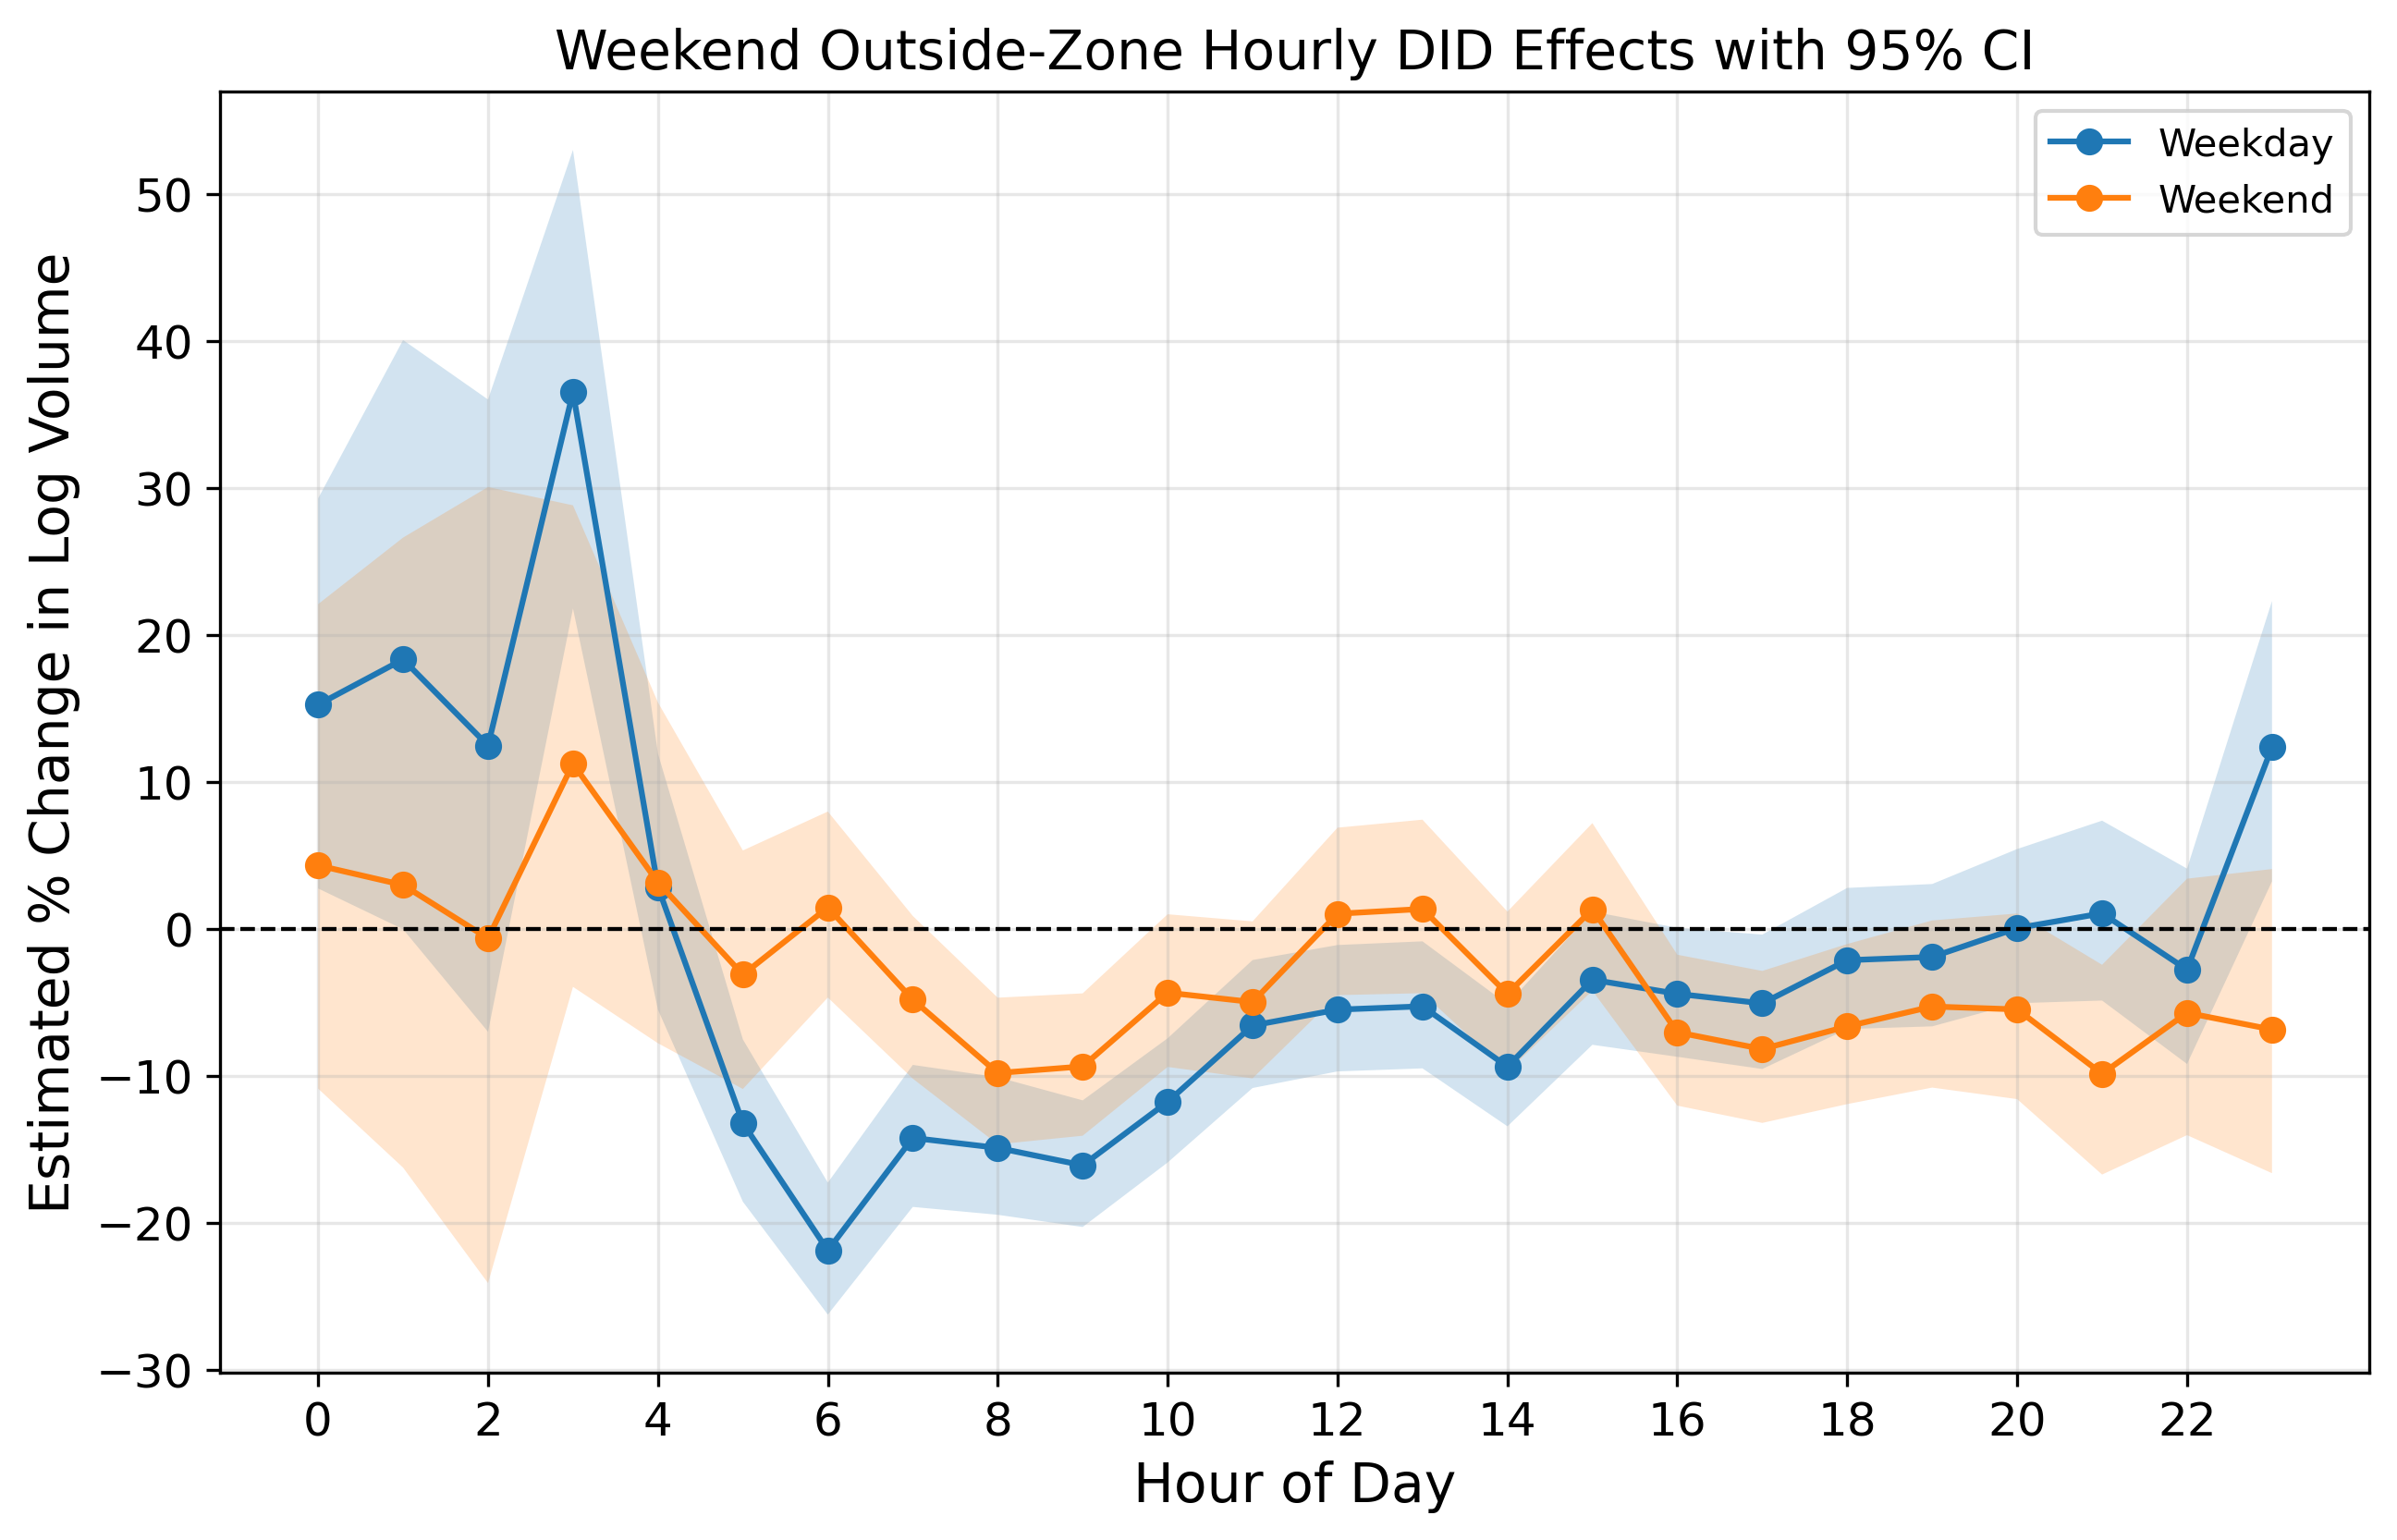

In [6]:
def plot_hourly_effects(hourly_effects, ax, color, label):
    x = hourly_effects['hour']
    y = hourly_effects['pct_change']
    ci_5 = hourly_effects['ci_lower_pct']
    ci_95 = hourly_effects['ci_upper_pct']
    p = ax.plot(x, y, marker='o', label=label, c=color)
    ax.fill_between(x, ci_5, ci_95, alpha=0.2, facecolor=color)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_xlabel('Hour of Day', fontsize=14)
    ax.set_ylabel('Estimated % Change in Log Volume', fontsize=14)
    ax.set_title('Weekend Outside-Zone Hourly DID Effects with 95% CI', fontsize=14)
    ax.set_xticks(range(0, 24, 2))
    ax.set_xticklabels(range(0, 24, 2), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.grid(alpha=0.3)
    ax.legend()
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
plot_hourly_effects(weekday_hourly_effects, ax, color='tab:blue', label='Weekday')
plot_hourly_effects(weekend_hourly_effects, ax, color='tab:orange', label='Weekend')
fig.savefig('figures/macro/hourly_treatment_effects.png', dpi=300)
plt.show()